### Sensitivity analysis for the between-host epidemic model
First import some necessary libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import style

# using the style for the plot
plt.style.use('seaborn-v0_8-bright')

### Code chunk 1: Model parameters and $R_h$

The parameter for the population-level epidemic model will be given in a vector of the form

$ x = (\Lambda_H, \Lambda_M, \mu_H, \mu_M, \beta_h, \beta_m, \sigma_H, \sigma_M, \gamma_H)$

Note that as discussed in the SM, the host population can be normalized i.e. $N^{*}= \Lambda_H/\mu_H = 1$.

In [2]:
# Mean parameters for DENV
xDENV = np.array([1, 1.01, 1, 0.07, 0.67, 0.39, 1/6, 1/8, 1/4.5])

# Mean parameters for ZIKV
xZIKV = np.array([1, 1.15, 1, 0.066, 0.96, 0.26, 1/8.5, 1/7, 1/5.5])

# Mean parameters for WNV
xWNV = np.array([1, 0.42, 1, 0.12, 0.44, 0.974, 1/0.5, 1/3.5, 1/2.3])


The basic reproduction number as function of the parameters

In [12]:
def Rh(x):
    """ This function gives Rh as a function of between-host parameters"""
    L_H, L_M, muH, muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    Rh_Numerator = sigmaM*betaH*sigmaH*betaM*Nm
    Rh_Denominator = (sigmaM + muM)*muM*(sigmaH + muH)*(gammaH + muH)*Nh
    Rh = np.sqrt(Rh_Numerator/Rh_Denominator)
    return Rh

print('reproduction number for DENV', Rh(xDENV))
print('reproduction number for ZIKV', Rh(xZIKV))
print('reproduction number for WNV', Rh(xWNV))
print('\n')

#------------------ Vector to host ratio for the mean values
NmNh_denv = (xDENV[1]/xDENV[3])/(xDENV[0]/xDENV[2])
print("Vector to host ratio DENV:", NmNh_denv)


NmNh_zikv = (xZIKV[1]/xZIKV[3])/(xZIKV[0]/xZIKV[2])
print("Vector to host ratio ZIKV:", NmNh_zikv)


NmNh_wnv = (xWNV[1]/xWNV[3])/(xWNV[0]/xWNV[2])
print("Vector to host ratio WNV:", NmNh_wnv)

reproduction number for DENV 2.0088427625458682
reproduction number for ZIKV 2.003625049363964
reproduction number for WNV 2.0223967662725144


Vector to host ratio DENV: 14.428571428571427
Vector to host ratio ZIKV: 17.424242424242422
Vector to host ratio WNV: 3.5


Next, the reproduction number $R_h$ is ploted as a function of the vector to host ratio. This result is useful for the calibration of mosquito recruitment rate.

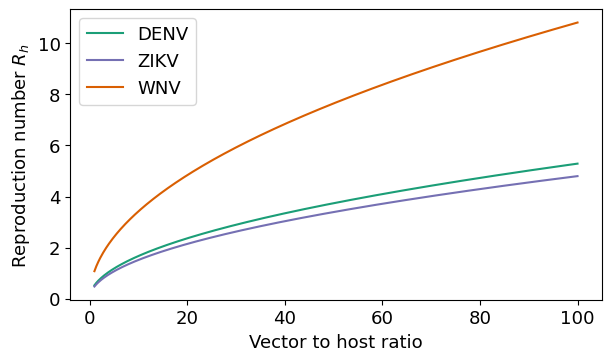

In [13]:
def Rh2(x, vector_host_ratio):
    """ This function gives Rh as a function of between-host parameters x and
    the vector to host ratio"""
    muH, muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[2], x[3], x[4], x[5], x[6], x[7], x[8]


    Rh_Numerator = sigmaM*betaH*sigmaH*betaM*vector_host_ratio
    Rh_Denominator = (sigmaM + muM)*muM*(sigmaH + muH)*(gammaH + muH)
    Rh = np.sqrt(Rh_Numerator/Rh_Denominator)
    return Rh

 
# Range for the vector to host ratio
NmNh = np.linspace(1, 100, 501) 

fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6,3.5), sharex=False, sharey=False, constrained_layout=True)
ax1.plot(NmNh, Rh2(xDENV, NmNh), label=r'DENV', color='#1b9e77')
ax1.plot(NmNh, Rh2(xZIKV, NmNh), label=r'ZIKV', color='#7570b3')
ax1.plot(NmNh, Rh2(xWNV, NmNh), label=r'WNV', color='#d95f02')
ax1.set_xlabel(r"Vector to host ratio", fontsize=13)
ax1.set_ylabel(r'Reproduction number $R_h$', fontsize=13)
ax1.legend(loc='best', fontsize=13)
ax1.tick_params(labelsize=13)
#plt.savefig("Rh.pdf")
plt.show()




### Sensitivity analysis 
Here, we investigate the sensitivity analysis of the equilibrium for the infected host and mosquitos classes

First, let's import the libraries

In [14]:
from SALib.sample.sobol import sample
from SALib.analyze.sobol import analyze

We start with the infected mosquito class at the equilibrium:

\begin{equation}
I_M^{*} = \dfrac{(R_h^{2} -1)\alpha_1 \alpha_2}{\beta_h \left( \frac{\beta_m\alpha_4}{N_M^{*}} + \frac{\alpha_2\alpha_3}{N_H^{*}}\right) },
\end{equation}

Note: Variations in the vector to host ratio are achieved varying the mosquito mortality rate (see SM).

In [15]:
def I_Mstar(x, recruitment_mosquito):
    """ Infected mosquitos (equilibrium) as function of  
    x = model parameters without recruiment and mortality rates, recruitment_mosquito determines the vector to host ratio.
    returns: i_M = equilibrium FRACTION for infected mosquitos"""

    # parameters to vary
    muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5]

    # fixed parameters
    L_H, muH = 1, 1
    L_M = recruitment_mosquito

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    # auxiliar alphas
    alpha1 = (sigmaH + muH)*(gammaH + muH)/sigmaH

    alpha2 = (sigmaM + muM)*muM/sigmaM

    alpha3 = (gammaH + muH)/sigmaH + 1 + gammaH/muH

    alpha4 = muM/sigmaM + 1

    # Reproduction number
    Rh_Numerator = sigmaM*betaH*sigmaH*betaM*Nm
    Rh_Denominator = (sigmaM + muM)*muM*(sigmaH + muH)*(gammaH + muH)
    Rh = np.sqrt(Rh_Numerator/Rh_Denominator)

    # definition of ImStar
    num = (Rh - 1)*alpha1*alpha2
    c1 = betaM*alpha4/Nm
    c2 = alpha2*alpha3/Nh
    den = betaH*(c1 + c2)
    I_M = num/den
    i_M = I_M/Nm
    return i_M

Computing the indices

In [17]:
#-define a function to evaluate the values of the parameters 
     
def evaluate(values, recruitment_mosquito):
    Y = np.zeros([values.shape[0]])
    for i, X in enumerate(values):
        Y[i] = I_Mstar(X, recruitment_mosquito)
    return Y


# ------------------------- Ranges for the exploration
# Dengue virus
boundsDENV = [[0.035, 0.15], [0.34, 1.0], [0.2, 0.6],  [0.08, 0.24], [0.06, 0.19], [0.11, 0.33]]


# Zika virus
boundsZIKV = [[0.035, 0.15], [0.48, 1.44], [0.13, 0.39],  [1/13, 1/3], [0.055, 0.18], [0.09, 0.27]]

# West-nile virus
boundsWNV = [[0.06, 0.18], [0.22, 0.66], [0.5, 1.45],  [0.3, 3], [0.15, 0.45], [0.22, 0.55]]



def problemRanges(ParamsBounds):
    problem = {
        'num_vars': 6,  # number of parameters 
        'names': np.array(['muM', 'betaH', 'betaM', 'sigmaH', 'sigmaM', 'gammaH']), 
        'bounds': ParamsBounds #ranges
    }
    return problem
    


# ------------Generate samples

number_of_samples = 2**14 # Note this value should be above 2**n where n is the number of parameters

param_valuesDENV = sample(problemRanges(boundsDENV), number_of_samples, calc_second_order=True)
param_valuesZIKV = sample(problemRanges(boundsZIKV), number_of_samples, calc_second_order=True)
param_valuesWNV = sample(problemRanges(boundsWNV), number_of_samples, calc_second_order=True)

# ------------Run model (example)

Ydenv = evaluate(param_valuesDENV, xDENV[1])
Yzikv = evaluate(param_valuesZIKV, xZIKV[1])
Ywnv = evaluate(param_valuesWNV, xWNV[1])


# ------------Perform analysis
Si_denv = analyze(problemRanges(boundsDENV), Ydenv, print_to_console=False)
Si_zikv = analyze(problemRanges(boundsZIKV), Yzikv, print_to_console=False)
Si_wnv = analyze(problemRanges(boundsWNV), Ywnv, print_to_console=False)


Plot 

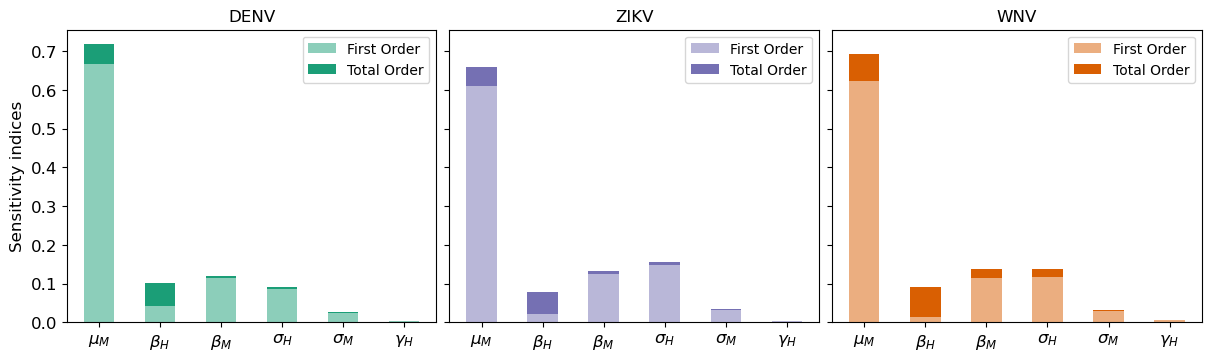

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,3.5), ncols=3, nrows=1, sharey=True, constrained_layout=True)


ind = np.arange(len(Si_denv['S1']))   # the x locations for the groups
width = 0.5    
#--------------------------------------------- DENV

p1_denv = ax1.bar(ind, Si_denv['S1'], width, align='center', color='#1b9e77', alpha=0.5)
p2_denv = ax1.bar(ind, Si_denv['ST']-Si_denv['S1'], width, align='center', bottom=Si_denv['S1'], color='#1b9e77')

ax1.set_ylabel('Sensitivity indices', fontsize=12)
ax1.set_title(r'DENV')
ax1.set_xticks(ind)
ax1.set_xticklabels((r'$\mu_M$', r'$\beta_{H}$', r'$\beta_{M}$', r'$\sigma_H$', r'$\sigma_M$', r'$\gamma_H$'))
ax1.legend((p1_denv[0], p2_denv[0]), ('First Order', 'Total Order'), loc='best')
ax1.tick_params(labelsize=12)

# --------------------------------------------ZIKV

p1_zikv = ax2.bar(ind, Si_zikv['S1'], width, align='center', color='#7570b3', alpha=0.5)
p2_zikv = ax2.bar(ind, Si_zikv['ST']-Si_zikv['S1'], width, align='center', bottom=Si_zikv['S1'], color='#7570b3')


ax2.set_title(r'ZIKV')
ax2.set_xticks(ind)
ax2.set_xticklabels((r'$\mu_M$', r'$\beta_{H}$', r'$\beta_{M}$', r'$\sigma_H$', r'$\sigma_M$', r'$\gamma_H$'))
ax2.legend((p1_zikv[0], p2_zikv[0]), ('First Order', 'Total Order'), loc='best')
ax2.tick_params(labelsize=12)

# --------------------------------------------WNV

p1_wnv = ax3.bar(ind, Si_wnv['S1'], width, align='center', color='#d95f02', alpha=0.5)
p2_wnv = ax3.bar(ind, Si_wnv['ST']-Si_wnv['S1'], width, align='center', bottom=Si_wnv['S1'], color='#d95f02')


ax3.set_title(r'WNV')
ax3.set_xticks(ind)
ax3.set_xticklabels((r'$\mu_M$', r'$\beta_{H}$', r'$\beta_{M}$', r'$\sigma_H$', r'$\sigma_M$', r'$\gamma_H$'))
ax3.legend((p1_wnv[0], p2_wnv[0]), ('First Order', 'Total Order'), loc='best')
ax3.tick_params(labelsize=12)
#plt.savefig("Sobol_Im.pdf", bbox_inches = 'tight')

plt.show()

The corresponding analysis should also be done for the infected host class

\begin{equation}
    I_H^{*} = \dfrac{\beta_h I_M^{*}}{ \alpha_1 + \beta_h \alpha_3 \frac{I_M^{*}}{N_H^{*}}}
\end{equation}

In [22]:
def I_Hstar(x, recruitment_mosquito):
    """ Infected mosquitos (equilibrium) as function of  
    x = model parameters without recruiment and mortality rates, recruitment_mosquito determines the vector to host ratio.
    returns: i_H = equilibrium FRACTION for infected host"""

    #parameters to vary
    muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5]

    # fixed parameters
    L_H, muH = 1, 1
    L_M = recruitment_mosquito

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    # auxiliar alphas
    alpha1 = (sigmaH + muH)*(gammaH + muH)/sigmaH

    alpha3 = (gammaH + muH)/sigmaH + 1 + gammaH/muH

    # definition of I_H
    I_M = I_Mstar(x, recruitment_mosquito)
    Numerator = betaH*I_M
    Denominator = alpha1 + betaH*alpha3*I_M/Nh
    
    i_H = (Numerator/Denominator)/Nh
    return i_H

Calculate the sensitivity indices 

In [23]:
#-define a function to evaluate the values of the parameters 

def evaluate2(values, recruitment_mosquito):
    Y = np.zeros([values.shape[0]])
    for i, X in enumerate(values):
        Y[i] = I_Hstar(X, recruitment_mosquito)
    return Y


# ------------Run model (example)

Ydenv2 = evaluate2(param_valuesDENV, xDENV[1])
Yzikv2 = evaluate2(param_valuesZIKV, xZIKV[1])
Ywnv2 = evaluate2(param_valuesWNV, xWNV[1])


# ------------Perform analysis
Si_denv2 = analyze(problemRanges(boundsDENV), Ydenv2, print_to_console=False)
Si_zikv2 = analyze(problemRanges(boundsZIKV), Yzikv2, print_to_console=False)
Si_wnv2 = analyze(problemRanges(boundsWNV), Ywnv2, print_to_console=False)





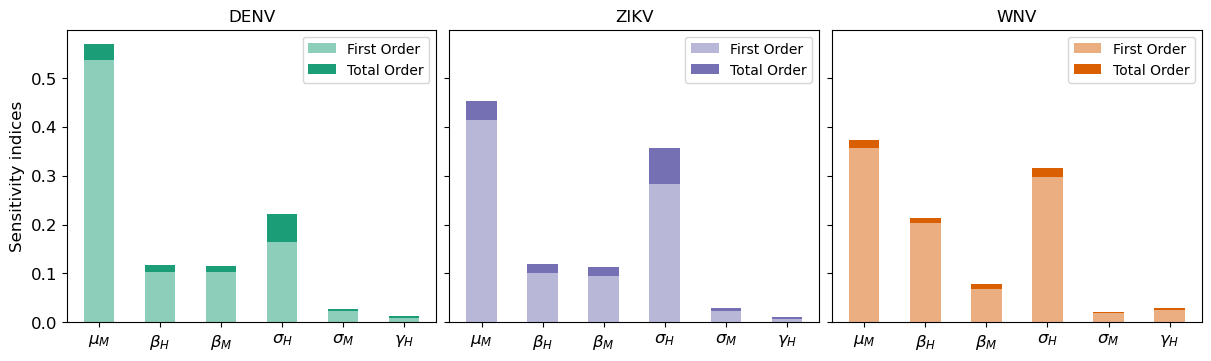

In [24]:
#-------------------------------- PLOT

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,3.5), ncols=3, nrows=1, sharey=True, constrained_layout=True)


ind = np.arange(len(Si_denv2['S1']))
width = 0.5 


#--------------------------------------------- DENV

p1_denv = ax1.bar(ind, Si_denv2['S1'], width, align='center', color='#1b9e77', alpha=0.5)
p2_denv = ax1.bar(ind, Si_denv2['ST']-Si_denv2['S1'], width, align='center', bottom=Si_denv2['S1'], color='#1b9e77')

ax1.set_ylabel('Sensitivity indices', fontsize=12)
ax1.set_title(r'DENV')
ax1.set_xticks(ind)
ax1.set_xticklabels((r'$\mu_M$', r'$\beta_{H}$', r'$\beta_{M}$', r'$\sigma_H$', r'$\sigma_M$', r'$\gamma_H$'))
ax1.legend((p1_denv[0], p2_denv[0]), ('First Order', 'Total Order'), loc='best')
ax1.tick_params(labelsize=12)


# --------------------------------------------ZIKV

p1_zikv = ax2.bar(ind, Si_zikv2['S1'], width, align='center', color='#7570b3', alpha=0.5)
p2_zikv = ax2.bar(ind, Si_zikv2['ST']-Si_zikv2['S1'], width, align='center', bottom=Si_zikv2['S1'], color='#7570b3')


ax2.set_title(r'ZIKV')
ax2.set_xticks(ind)
ax2.set_xticklabels((r'$\mu_M$', r'$\beta_{H}$', r'$\beta_{M}$', r'$\sigma_H$', r'$\sigma_M$', r'$\gamma_H$'))
ax2.legend((p1_zikv[0], p2_zikv[0]), ('First Order', 'Total Order'), loc='best')
ax2.tick_params(labelsize=12)


# --------------------------------------------WNV

p1_wnv = ax3.bar(ind, Si_wnv2['S1'], width, align='center', color='#d95f02', alpha=0.5)
p2_wnv = ax3.bar(ind, Si_wnv2['ST']-Si_wnv2['S1'], width, align='center', bottom=Si_wnv2['S1'], color='#d95f02')


ax3.set_title(r'WNV')
ax3.set_xticks(ind)
ax3.set_xticklabels((r'$\mu_M$', r'$\beta_{H}$', r'$\beta_{M}$', r'$\sigma_H$', r'$\sigma_M$', r'$\gamma_H$'))
ax3.legend((p1_wnv[0], p2_wnv[0]), ('First Order', 'Total Order'), loc='best')
ax3.tick_params(labelsize=12)
#plt.savefig("Sobol_Ih.pdf", bbox_inches = 'tight')


plt.show()